# aims
* across group same role vs. same group across role vs. (null) across group across role
* 리콜해내는 이벤트는 둘 중 어떤 상황에서 더 유사할까?
* quantify1: event 간 similarity (content level)
* quantify2: across group role

1. 일단 각 그룹별 벌어졌던 이벤트를 쪼갬 (모든 그룹 sharedeb 준비)
2. Day1 각 이벤트의 content level vector를 구함 (only nv, USE 사용) -----quantify1
    1. USE 성능확인을 해봐야 함: 각 문장*을 넣고 pairwise vector similarity를 구하여 그것이 육안으로 확인한 내용적 유사성에 부합하는지
    2. *각 문장: raw, exclude stopwords, only nv 이렇게 세 단계로 테스트
3. 각 그룹의 각 이벤트에서 leader role(leader idx 1~3)을 정의하는 방법 구현(speaker와 NB_SBJ 등 구문분석 사용) -----quantify2
4. Day1에 대한 Day2의 리콜 태깅을 불러옴
5. 일단 각 그룹에서 전체 day1 이벤트들 대비 리콜된 이벤트들의 벡터 similarity에 특이점이 있는지 확인, across group 특이점이 있는지 확인 -----within group vector similarity가 월등히 높지 않을까 하는 걱정에서 비롯
6. (same group across role) 리콜된 day2의 이벤트들의 day1 벡터들의 similarity 계산 -----pairwise로 전부?
7. (across group same role) 리콜된 day2의 이벤트들의 day1 벡터들의 similarity 계산 -----pairwise로 전부; 위와 동일하게
8. (across group across role) 리콜된 day2의 이벤트들의 day1 벡터들의 similarity 계산 -----pairwise로 전부; null로 사용

# USE

In [28]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from scipy.spatial import distance

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [90]:
DATADIR = '/home/jiunchoi/OFD/OFD_BHV_clean'
group = 5
sub = 1
groupsub = '0'+str(group)+'0'+str(sub)

names = []
with open(f"{DATADIR}/subnames", "r") as f:
    names.extend(f.read().split('\n'))

subname = names[group-1].split()
subname = subname[1:]

In [91]:
data_transcript = pd.read_excel(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} sharedeb.xlsx')
data_script = data_transcript['sentence']
sharedeb = np.array(data_transcript['sharedeb'])
sentence_embedding = np.array(embed(data_script))

event_semantic_vectors = np.zeros((int(sharedeb[-1]),sentence_embedding.shape[-1]))
for i in range (1,int(sharedeb[-1])+1):
    event_semantic_vectors[i-1] = np.mean(sentence_embedding[sharedeb==i,:],axis=0)

In [92]:
np.save(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} event_semantic_vectors.npy',event_semantic_vectors)
event_semantic_vectors.shape

(193, 512)

/home/jiunchoi/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jiunchoi/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(121, 3)


Text(0.5, 1.0, 't-SNE Visualization')

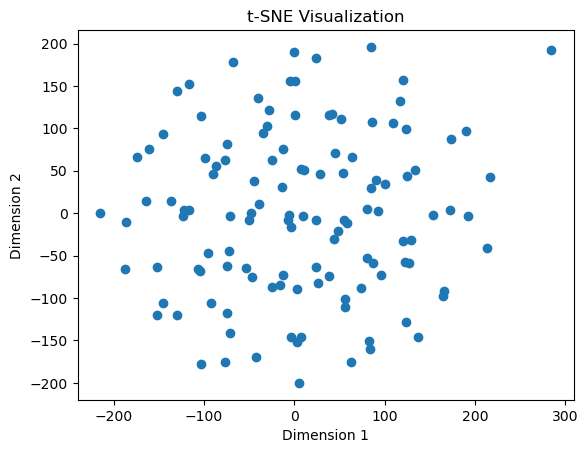

In [69]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

# Generate a random matrix of shape (140, 512)
matrix = event_semantic_vectors

# Create a t-SNE object with desired parameters
tsne = TSNE(n_components=3, random_state=0)

# Apply t-SNE on the matrix
embedded_data = tsne.fit_transform(matrix)
print(embedded_data.shape)

# Create a scatter plot of the embedded_data
plt.scatter(embedded_data[:, 0], embedded_data[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization')

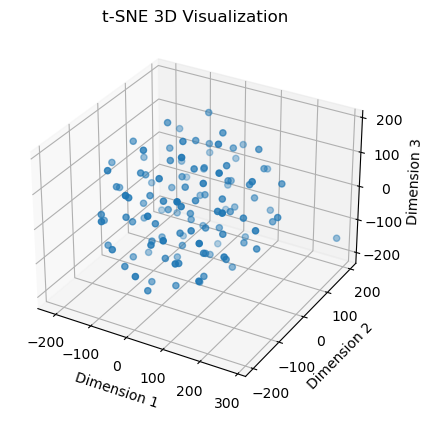

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot of the embedded_data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2])
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('t-SNE 3D Visualization')

# Show the plot
plt.show()


In [95]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

group=3
# Generate a random matrix of shape (140, 512)
matrix = np.load(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} event_semantic_vectors.npy')

# Create a KMeans object with desired parameters
kmeans = KMeans(n_clusters=3, random_state=0)

# Apply k-means clustering on the matrix
kmeans.fit(matrix)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Convert the cluster labels to a Pandas DataFrame for easier analysis
df = pd.DataFrame({'Data Point': range(len(cluster_labels)), 'Cluster': cluster_labels})

# Print the first few rows of the DataFrame
for i in range (len(df)):
    print(df['Cluster'][i])

1
1
1
1
0
0
0
1
0
2
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
0
1
0
1
1
1
1
1
0
1
0
2
1
1
1
1
0
1
1
1
1
1
0
1
1
0
1
0
0
0
0
1
0
1
0
0
0
2
1
1
0
0
0
0
0
0
1
0
0
1
0
0
2
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
0
0
1
0
0
0
0
2
0
0
0
0
0
1
0
0
1
0
0
0
0
2
0
1
0
0
0
1
0
1
1


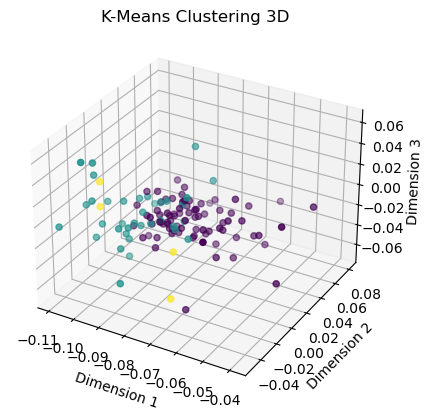

In [77]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(matrix[:, -1], matrix[:, -2], matrix[:, -3], c=cluster_labels)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('K-Means Clustering 3D')

plt.show()


Text(0.5, 0.92, 'PCA 3D Visualization')

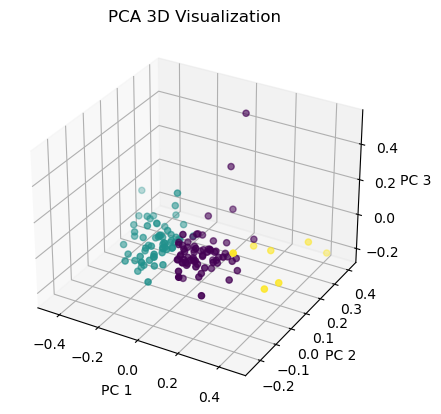

In [129]:
from sklearn.decomposition import PCA

group=4
matrix = np.load(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} event_semantic_vectors.npy')

# Create a KMeans object with desired parameters
pca = PCA(n_components=3)

embedded_data = pca.fit_transform(matrix)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], c=df['Cluster'])
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('PCA 3D Visualization')

In [124]:
embedded_data.shape

(193, 193)

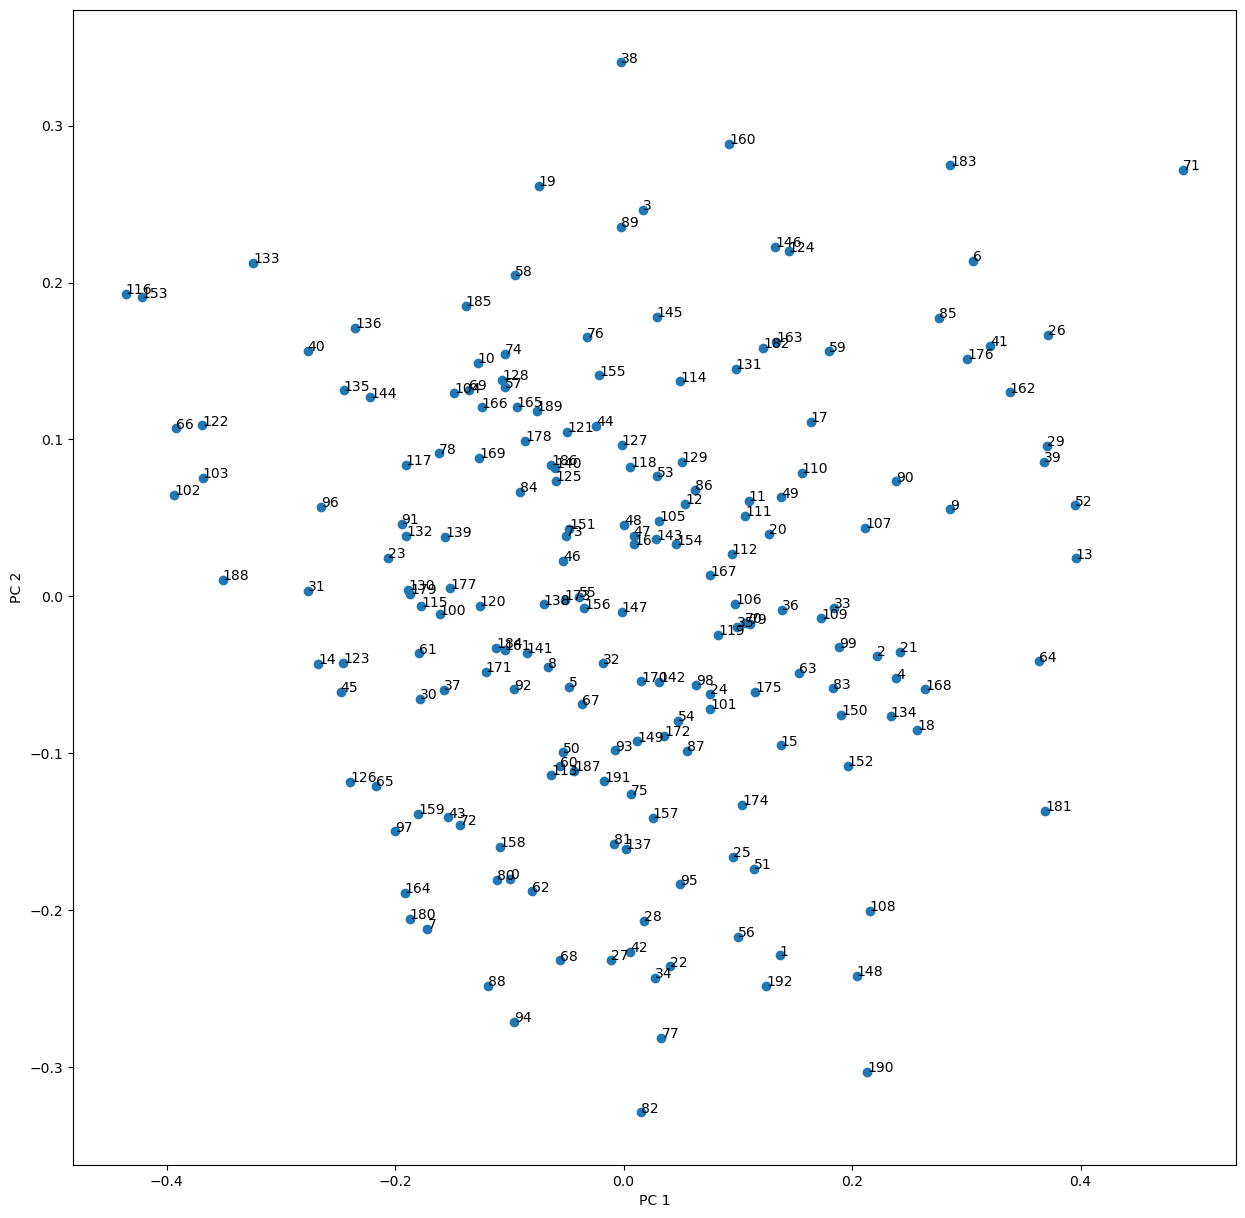

In [127]:
plt.figure(figsize=(15,15))
plt.scatter(embedded_data[:, 0], embedded_data[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
for i, (x, y) in enumerate(zip(embedded_data[:, 0], embedded_data[:, 1])):
    plt.annotate(str(i), (x, y))

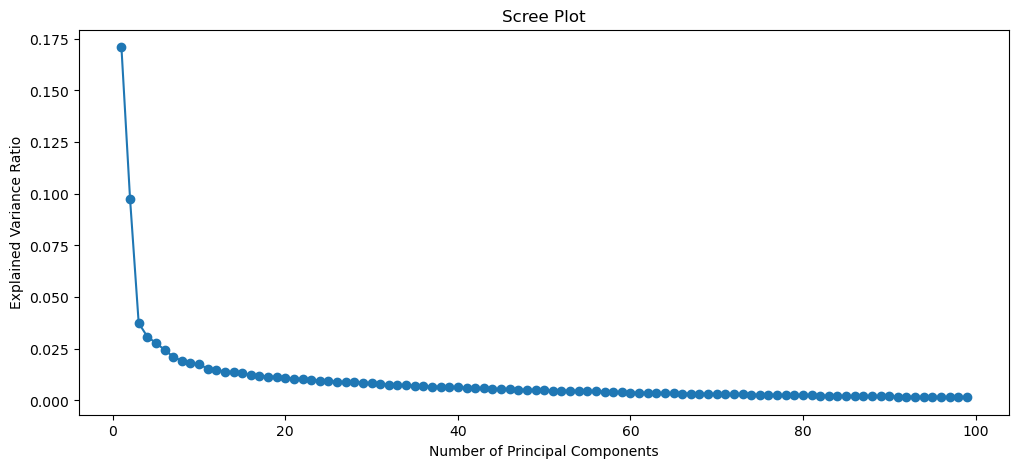

In [125]:
import matplotlib.pyplot as plt

# Get the explained variance ratios
explained_variances = pca.explained_variance_ratio_

# Plot the scree plot
n=100
plt.figure(figsize=(12,5))
plt.plot(range(1, n), explained_variances[:n-1], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

# Show the plot
plt.show()


# sharedeb를 불러와서 모두 다 nan인 evno의 cossim vs. 한명한테서라도 recalled evno's cossim 각각이 유의하게 다른지

In [182]:
group=2
keys = [f'sub-0{group}01',f'sub-0{group}02',f'sub-0{group}03']

data_transcript = pd.read_excel(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} sharedeb.xlsx')
sharedeb = np.array(data_transcript['sharedeb'])
data_recs = np.array(data_transcript[keys])
notrecalled_evidx=[]

for i in range(len(sharedeb)):
    count=0
    for j in range(3):
        if type(data_recs[i,j])!=str and np.isnan(data_recs[i,j])==True:
            count+=1
    if count==3:
        if sharedeb[i] not in notrecalled_evidx:
            notrecalled_evidx.append(sharedeb[i])

recalled_evidx=[]

for i in range(len(sharedeb)):
    count=0
    for j in range(3):
        if type(data_recs[i,j])==str or np.isnan(data_recs[i,j])==False:
            count+=1
    if count==3:
        if sharedeb[i] not in recalled_evidx:
            recalled_evidx.append(sharedeb[i])

[14,
 15,
 16,
 17,
 31,
 32,
 33,
 34,
 40,
 44,
 45,
 52,
 53,
 54,
 55,
 59,
 60,
 61,
 63,
 64,
 65,
 83,
 84,
 88,
 90,
 96,
 97,
 98,
 111,
 118,
 119]

In [174]:
np.isnan(data_recs[13][0])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [176]:
type(data_recs[13][0])

str

In [177]:
np.isnan(['dd'])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# distance.cosine(sentence_embedding[a,:],sentence_embedding[b,:])